# OOD Detection
The purpose of this lab project is to enhance our understanding of OOD detection. After accomplishing the lab project, you should be able to:
- Code different OOD score functions and use them for OOD detection.
- Perform benchmarking experiments involving different OOD score functions and different metrics.
- Visualize OOD detection results and check for common mistakes in OOD detection experiments.

As usual, we start by importing the necessary libraries.

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import roc_auc_score, precision_recall_curve
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## 1. Data
The ultimate purpose of this notebook is to perform a benchmarking experiment in order to compare multiple OOD scores and OOD detection algorithms. To that end, we will use three different data sets:
1. The **Cifar-10 train** dataset in order to train a simple convolutional neural network for the task of image classification.
2. The **Cifar-10 test** set as the *in-distribution* dataset (i.e. the dataset of normal examples), for evaluating the different OOD scores.
3. (A subset of) The **SVHN test** set as the *out-of-distribution* dataset (i.e. the dataset of anomalous examples), for evaluating the different OOD scores.



In [12]:
# Data loading and preprocessing
batch_size = 128

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

cifar_train = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
cifar_test = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)
svhn_test = datasets.SVHN(root='./data', split='test', transform=transform, download=True)

# Extract 10_000 random images from the svhn_test set
svhn_test, _ = torch.utils.data.random_split(svhn_test, [10_000, len(svhn_test) - 10_000])

train_loader = DataLoader(cifar_train, batch_size=batch_size, shuffle=True)
cifar_test_loader = DataLoader(cifar_test, batch_size=batch_size, shuffle=False)
svhn_test_loader = DataLoader(svhn_test, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified
Using downloaded and verified file: ./data/test_32x32.mat


In [13]:
print(f"Number of training samples: {len(cifar_train)}")
print(f"Number of test samples: {len(cifar_test)}")
print(f"Number of SVHN test samples: {len(svhn_test)}")

Number of training samples: 50000
Number of test samples: 10000
Number of SVHN test samples: 10000


## 2. CNN Classifier
We will first train a CNN Classifier on the Cifar-10 training data, for the task of classifying the Cifar-10 images.

The architecture of the CNN should be:
- A convolutional layer with 32 filters, kernel size 3, stride 1 and padding 1.
- A ReLU activation
- A max pooling layer with kernel size 2.
- A convolutional layer with 64 filters, kernel size 3, stride 1 and padding 1.
- A ReLU activation
- A max pooling layer with kernel size 2.
- A fully connected layer with 128 neurons.
- A ReLU activations (the activations after this layer will be called the "features of the penultimate layer").
- A fully connected layer with 10 neurons.

This CNN will output the logit values.

**Exercise** Define a CNN having the above architecture by implementing the `__init__` and `forward` methods below. Bare in mind that some of the OOD scores we will define require access to the features of the penultimate layer.
- Add a `return_features` argument to the `forward` method, defaulting to `False`. If `return_features` is set to `True`, the `forward` method should return the features of the penultimate layer instead of the logit values.

In [14]:
# Define the SimpleCNN class
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # Define the first convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        # Define the second convolutional layer
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        # Define the fully connected layers
        self.fc1 = nn.Linear(in_features=64 * 8 * 8, out_features=128)  # Input size is reduced after pooling
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(in_features=128, out_features=10)  # Output layer for 10 classes

    def forward(self, x, return_features=False):
        # Apply the first convolutional layer
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        # Apply the second convolutional layer
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        # Flatten the tensor for fully connected layers
        x = x.view(x.size(0), -1)  # Flatten the features

        # Apply the first fully connected layer
        features = self.fc1(x)
        x = self.relu3(features)

        # Apply the final output layer
        logits = self.fc2(x)

        # Return features of the penultimate layer if requested
        if return_features:
            return logits, features
        return logits


## 3. Training
We will train the above CNN on the Cifar-10 training set.

**Exercise.** Train the CNN:
- For 5 epochs
- Using a learning rate of 0.001
- Choose an appropriate loss function
- Using the Adam optimizer
- Print the mean loss of the epoch at the end of each epoch.
- *Optional.* You can choose to monitor the training by printing the train/test accuracy too.

In [15]:
model = SimpleCNN().to(device)

In [16]:
criterion = nn.CrossEntropyLoss()  # Suitable for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 5
# Training loop
def train_model():
    model.train()  # Set the model to training mode
    for epoch in range(num_epochs):
        total_loss = 0
        correct = 0
        total = 0
        for images, labels in train_loader:
            # Move data to device if using GPU
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        # Print epoch statistics
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {total_loss / len(train_loader):.4f}, "
              f"Accuracy: {100 * correct / total:.2f}%")

# Optional: Evaluate on test set
def evaluate_model():
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in cifar_test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    print(f"Test Accuracy: {100 * correct / total:.2f}%")

# Train and evaluate the model
train_model()
evaluate_model()

Epoch [1/5], Loss: 1.4132, Accuracy: 49.30%
Epoch [2/5], Loss: 1.0393, Accuracy: 63.41%
Epoch [3/5], Loss: 0.8848, Accuracy: 68.99%
Epoch [4/5], Loss: 0.7785, Accuracy: 72.78%
Epoch [5/5], Loss: 0.6849, Accuracy: 76.11%
Test Accuracy: 71.96%


In [17]:
train_model()

Epoch [1/5], Loss: 0.6074, Accuracy: 78.74%
Epoch [2/5], Loss: 0.5305, Accuracy: 81.65%
Epoch [3/5], Loss: 0.4541, Accuracy: 84.38%
Epoch [4/5], Loss: 0.3863, Accuracy: 86.63%
Epoch [5/5], Loss: 0.3187, Accuracy: 89.23%


**Exercise.** Print the test loss and the test accuray after training.

In [18]:
# TODO: print test loss and accuracy

## 4. OOD Metrics
The objective of this section is to define the different OOD metrics studied during the lectures. Recall that we have seen two kinf of metrics:
1. Fixed-threshold metrics.
2. Threshold-independent metrics.

### 4.1. Fixed-threshold metrics
We will start to define the metrics for OOD detectors with a fixed threshold. The inputs to all of our metrics below will be:
- The `scores_negatives` nupy array: an array containing the scores for the ground truth negative images (i.e. the Cifar-10 test images).
- The `scores_positives` numpy array: an array containing the scores for the ground truth positive images (i.e. the SVHN test images).
- The `threshold` floating point number. The threshold value $\tau$ such that such that our OOD detector classifies examples according to their score as follwos:
$$\begin{cases}
s \leq \tau\quad &⇒\quad \text{negative}\\
s > \tau\quad &⇒\quad \text{positive}
\end{cases}$$
- Any other parameters necessary for the metric in question.

**Exercise.** Define the functions below:
1. A `confusion_matrix` function that outputs the number of *false positives*, *true positives*, *true negatives* and *false negatives*.
2. A `tpr_fpr` function that outputs the  *true positive rate* and *false positive rate*.
3. An `accuracy` function that outputs the accuracy.
4. A `precission_recall` function that outputs the *precision* and the *recall*.
5. A `f_beta` function that takes an additional input argument `beta` and returns the corresponding $F_\beta$ score.

In [33]:


def confusion_matrix(scores_negatives, scores_positives, threshold):
    """
    Compute the confusion matrix components: FP, TP, TN, FN.
    """
    # Negative images classified as positive (false positives)
    fp = np.sum(scores_negatives > threshold)
    # Positive images classified as positive (true positives)
    tp = np.sum(scores_positives > threshold)
    # Negative images classified as negative (true negatives)
    tn = np.sum(scores_negatives <= threshold)
    # Positive images classified as negative (false negatives)
    fn = np.sum(scores_positives <= threshold)

    return fp, tp, tn, fn

def tpr_fpr(scores_negatives, scores_positives, threshold):
    """
    Compute the true positive rate (TPR) and false positive rate (FPR).
    """
    fp, tp, tn, fn = confusion_matrix(scores_negatives, scores_positives, threshold)
    # True positive rate: TP / (TP + FN)
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
    # False positive rate: FP / (FP + TN)
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0

    return tpr, fpr

def accuracy(scores_negatives, scores_positives, threshold):
    """
    Compute the accuracy.
    """
    fp, tp, tn, fn = confusion_matrix(scores_negatives, scores_positives, threshold)
    # Accuracy: (TP + TN) / (Total)
    total = tp + tn + fp + fn
    acc = (tp + tn) / total if total > 0 else 0

    return acc

def precision_recall(scores_negatives, scores_positives, threshold):
    """
    Compute the precision and recall.
    """
    fp, tp, tn, fn = confusion_matrix(scores_negatives, scores_positives, threshold)
    # Precision: TP / (TP + FP)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    # Recall: TP / (TP + FN)
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0

    return precision, recall

def f_beta(scores_negatives, scores_positives, threshold, beta):
    """
    Compute the F-beta score.
    """
    precision, recall = precision_recall(scores_negatives, scores_positives, threshold)
    # F-beta score: (1 + beta^2) * (Precision * Recall) / (beta^2 * Precision + Recall)
    beta_squared = beta ** 2
    f_beta_score = (1 + beta_squared) * (precision * recall) / (beta_squared * precision + recall) if (beta_squared * precision + recall) > 0 else 0

    return f_beta_score

def fixed_threshold_metrics(scores_negatives, scores_positives, threshold):
    """
    Compute fixed-threshold metrics: Accuracy, TPR, Precision, Recall, F1.

    Args:
    - scores_negatives: Scores for negative samples.
    - scores_positives: Scores for positive samples.
    - threshold: Threshold value.

    Returns:
    - metrics: Dictionary of computed metrics.
    """
    # Compute confusion matrix
    fp, tp, tn, fn = confusion_matrix(scores_negatives, scores_positives, threshold)

    # Compute individual metrics
    acc = accuracy(scores_negatives, scores_positives, threshold)
    tpr, _ = tpr_fpr(scores_negatives, scores_positives, threshold)  # TPR = Recall
    precision, recall = precision_recall(scores_negatives, scores_positives, threshold)
    f1 = f_beta(scores_negatives, scores_positives, threshold, beta=1)  # F1 = F-beta with beta=1

    # Store results
    return {
        'Accuracy': acc,
        'TPR': tpr,
        'Precision': precision,
        'Recall': recall,
        'F1': f1
    }


### 4.2. Threshold-independent metrics
**Exercise.** Define the function `roc_auc` that:
- Takes as input the `scores_negatives` and `scores_positives` numpy arrays.
- Plots the *ROC curve*.
- Returns the value of the *AUROC* as the area under the *ROC curve*.

In [20]:
def roc_auc(scores_negatives, scores_positives):
    """
    Computes the ROC curve, plots it, and returns the AUROC.

    Args:
    - scores_negatives: numpy array of scores for negative samples.
    - scores_positives: numpy array of scores for positive samples.

    Returns:
    - auroc: Area under the ROC curve.
    """
    # Combine scores and create labels
    scores = np.concatenate((scores_negatives, scores_positives))
    labels = np.concatenate((np.zeros_like(scores_negatives), np.ones_like(scores_positives)))

    # Sort scores and labels by scores in ascending order
    sorted_indices = np.argsort(scores)
    scores = scores[sorted_indices]
    labels = labels[sorted_indices]

    # Initialize TPR and FPR
    tpr = []
    fpr = []
    n_pos = np.sum(labels)
    n_neg = len(labels) - n_pos

    tp = n_pos
    fp = n_neg

    # Loop through all thresholds (i.e., all scores)
    for i in range(len(scores)):
        # Update TPR and FPR
        tpr.append(tp / n_pos if n_pos > 0 else 0)
        fpr.append(fp / n_neg if n_neg > 0 else 0)

        # If the current score is a positive label, decrement tp
        if labels[i] == 1:
            tp -= 1
        else:  # Otherwise, decrement fp
            fp -= 1

    # Convert TPR and FPR lists to numpy arrays
    tpr = np.array(tpr)
    fpr = np.array(fpr)

    # Compute AUROC using the trapezoidal rule
    auroc = np.trapz(tpr, fpr)

    # Plot the ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"ROC Curve (AUROC = {auroc:.4f})")
    plt.plot([0, 1], [0, 1], 'r--', label="Random Classifier")
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.legend()
    plt.grid()
    plt.show()

    return auroc



## 5. OOD Scores
In this section, we will implement the different OOD scores seen during the lecture. Recall that we can split the different OOD scores into two score families:
1. Logit-based scores.
2. Feature-based scores.

### 5.1. Logit-based scores
Logit-based scores are simpler to implement than feature-based scores. We will implement each of the logit-based scores as a function that takes as inputs the `logits` array of logits of the different test points,
and returns the array of test point scores.

**Exercise.** Complete the functions below with the formulas seen during the lecture.

In [22]:
# Maximum Logit Score (MLS)
def mls(logits):
    """
    Computes the Maximum Logit Score (MLS).
    Args:
    - logits: numpy array of logits for each test point (shape: [num_samples, num_classes]).

    Returns:
    - scores: numpy array of MLS scores (shape: [num_samples]).
    """
    # MLS: Max of the logit values for each test point
    scores = np.max(logits, axis=1)
    return scores

# Maximum Softmax Probability (MSP)
def msp(logits):
    """
    Computes the Maximum Softmax Probability (MSP).
    Args:
    - logits: numpy array of logits for each test point (shape: [num_samples, num_classes]).

    Returns:
    - scores: numpy array of MSP scores (shape: [num_samples]).
    """
    # Compute softmax probabilities
    exp_logits = np.exp(logits - np.max(logits, axis=1, keepdims=True))  # For numerical stability
    softmax_probs = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)
    # MSP: Max of the softmax probabilities
    scores = np.max(softmax_probs, axis=1)
    return scores

# Energy Score
def energy(logits, temp=1):
    """
    Computes the Energy score.
    Args:
    - logits: numpy array of logits for each test point (shape: [num_samples, num_classes]).
    - temp: Temperature scaling parameter (default=1).

    Returns:
    - scores: numpy array of Energy scores (shape: [num_samples]).
    """
    # Energy: -T * log(sum(exp(logits / T)))
    energy_scores = -temp * np.log(np.sum(np.exp(logits / temp), axis=1))
    return energy_scores

# Entropy Score
def entropy(logits):
    """
    Computes the Entropy score.
    Args:
    - logits: numpy array of logits for each test point (shape: [num_samples, num_classes]).

    Returns:
    - scores: numpy array of Entropy scores (shape: [num_samples]).
    """
    # Compute softmax probabilities
    exp_logits = np.exp(logits - np.max(logits, axis=1, keepdims=True))  # For numerical stability
    softmax_probs = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)
    # Entropy: -sum(p * log(p))
    entropy_scores = -np.sum(softmax_probs * np.log(softmax_probs + 1e-12), axis=1)  # Add epsilon for stability
    return entropy_scores


### 5.2. DKNN
In this section we define a class `DKNN` to compute the Deep $K$-nearest neighbor score. This score is more involved than the previous ones for two main reasons:
- It employs the activations of the penultimate layer of the CNN rather than the logit or softmax values.
- It requires a fitting dataset in order to compute distances of the test images with respect to the images in the fitting dataset. We will be using the Cifar-10 training set as fitting dataset.

*Exercise.* Complete the following methods in the class `DKNN` below:
1. The `_l2_normalization` method that computes that normalizes a batch of feature vectors by dividing each feature vector by its $\ell_2$ norm.
2. The `compute_scores` function that computes the distance from each of the test points to its $k$-th nearest neighbor in the fit dataset. The distances are computed between the normalized feature representations. The test points are processed in batches to avoid memory issues.

In [23]:
import torch

class DKNN:
    def __init__(self, k=50, batch_size=256):
        """
        Initializes the DKNN class.

        Args:
        - k: Number of nearest neighbors to consider.
        - batch_size: Batch size for processing test points.
        """
        self.k = k
        self.batch_size = batch_size
        self.fit_features = None

    def _l2_normalization(self, feat):
        """
        Normalizes a batch of feature vectors by dividing each vector by its ℓ2 norm.

        Args:
        - feat: Tensor of feature vectors (size: [num_samples, feature_dim]).

        Returns:
        - Normalized feature vectors (same size as input).
        """
        # Compute the norm of each feature vector and add a small constant for numerical stability
        norms = torch.norm(feat, p=2, dim=1, keepdim=True) + 1e-12
        return feat / norms

    def fit(self, fit_dataset):
        """
        Fits the DKNN model using the fitting dataset (e.g., CIFAR-10 training set).

        Args:
        - fit_dataset: Tensor of feature representations of the fitting dataset
                       (size: [num_fit_samples, feature_dim]).
        """
        # Normalize the feature vectors in the fit dataset
        self.fit_features = self._l2_normalization(fit_dataset)

    def compute_scores(self, test_features):
        """
        Computes the DKNN scores for the test features.

        Args:
        - test_features: Tensor of feature representations of test samples
                         (size: [num_test_samples, feature_dim]).

        Returns:
        - scores: Numpy array of distances to the k-th nearest neighbor for each test sample
                  (size: [num_test_samples]).
        """
        # Normalize the test feature vectors
        test_features = self._l2_normalization(test_features)
        scores = []

        # Process test features in batches to avoid memory issues
        for i in range(0, test_features.size(0), self.batch_size):
            batch = test_features[i:i + self.batch_size]  # Get the current batch of test features
            # Compute pairwise distances between the batch and the fit dataset
            distances = torch.cdist(batch, self.fit_features, p=2)  # (batch_size, num_fit_samples)
            # Sort distances and extract the k-th nearest neighbor distance
            kth_distances = torch.sort(distances, dim=1).values[:, self.k - 1]  # (batch_size,)
            scores.append(kth_distances)

        # Concatenate scores from all batches
        return torch.cat(scores, dim=0).cpu().numpy()


### 5.3. Mahalanobis
In this section we define a class `Mahalanobis` to compute the Mahalanobis score. This class is similar to the `DKNN` for the same reasons as before:
- It employs the activations of the penultimate layer of the CNN rather than the logit or softmax values.
- It requires a fitting dataset in order to compute distances of the test images with respect to the images in the fitting dataset. We will be using the Cifar-10 training set as fitting dataset.

*Exercise.* Complete the following methods in the class `Mahalanobis` below:
1. The `fit` method that fits per-class mean vectors and a common covariance matrix to the fitting dataset.
2. The `_mahalanobis_distance` method that computes the Mahalanobis distance of a given vector with respect to the gaussian law parametrized by its mean vector and covariance matrix.
3. The `compute_scores` function that uses the two previous methods to compute the Mahalanobis score of all test points by taking the maximum of Mahalanobis distances over the set of different classes/labels.

In [29]:
import torch

class Mahalanobis:
    def __init__(self):
        self.mus = None  # Dictionary to store per-class mean vectors
        self.inv_cov = None  # Inverse covariance matrix
        self.labels = None  # Unique labels in the fitting dataset

    def fit(self, features, labels):
        """
        Fits per-class mean vectors and a common covariance matrix to the fitting dataset.

        Args:
        - features: Tensor of feature representations (size: [num_samples, feature_dim]).
        - labels: Tensor of corresponding labels (size: [num_samples]).
        """
        self.labels = torch.unique(labels)  # Extract unique labels
        self.mus = {}
        covs = []

        # Compute per-class mean vectors and covariance matrices
        for label in self.labels:
            class_features = features[labels == label]  # Select features of the current class
            mu = class_features.mean(dim=0)  # Mean vector for the class
            self.mus[label.item()] = mu
            # Covariance matrix for the class (scaled by the number of samples)
            cov = torch.cov(class_features.T) * class_features.size(0)
            covs.append(cov)

        # Compute the common covariance matrix
        cov = sum(covs) / features.size(0)  # Aggregate covariance over all classes
        self.inv_cov = torch.linalg.pinv(cov)  # Compute pseudo-inverse of covariance matrix

    def _mahalanobis_distance(self, x, mu, inv_cov):
        """
        Computes the Mahalanobis distance of a vector to a Gaussian distribution.

        Args:
        - x: Feature vector (size: [feature_dim]).
        - mu: Mean vector (size: [feature_dim]).
        - inv_cov: Inverse covariance matrix (size: [feature_dim, feature_dim]).

        Returns:
        - distance: Mahalanobis distance (scalar).
        """
        delta = x - mu  # Difference from the mean
        distance = torch.sqrt(delta @ inv_cov @ delta.T)  # Mahalanobis distance formula
        return distance

    def compute_scores(self, test_features):
        """
        Computes the Mahalanobis score of all test points.

        Args:
        - test_features: Tensor of feature representations of test samples (size: [num_test_samples, feature_dim]).

        Returns:
        - scores: Numpy array of Mahalanobis scores for each test point (size: [num_test_samples]).
        """
        scores = []
        for test_feature in test_features:
            # Compute Mahalanobis distances to all class means
            distances = torch.tensor([
                self._mahalanobis_distance(test_feature, self.mus[label.item()], self.inv_cov)
                for label in self.labels
            ])
            # The Mahalanobis score is the maximum distance
            scores.append(distances.max())
        return torch.stack(scores).cpu().numpy()


## 6. Score Comparison
The objective of this section is to compare the different OOD scores that we have just defined. Note that in order to use the *threshold-dependent metrics*, we need to pick a threshold for each of the scores.

Picking the same threshold for all scores *is not* a proper way to compare the different scores, since thy are scaled differently. A common way to perform a more "fair" comparison is to do the following:
1. Fix a target TPR, e.g. 0.9.
2. Compute the threshold $\tau$ such that the TPR on the SVHN test dataset is equal to the target TPR 0.9.
3. Compute the remaining fixed-threshold metrics for such $\tau$.

**Exercise.** Define the function `compute_threshold` that:
- Takes as inputs `scores`, a numpy array of scores and a `target_tpr`, a value between 0 and 1 defaulting to 0.95.
- Assuming that the array of `scores` contains the scores of the positive examples, the function computes and returns the value of the threshold $\tau$ that achieves the desired `target_tpr`.

In [25]:
def compute_threshold(scores, target_tpr=0.95):
    """
    Computes the threshold τ to achieve the desired target TPR.

    Args:
    - scores: numpy array of scores for the positive examples.
    - target_tpr: Desired target True Positive Rate (default=0.95).

    Returns:
    - threshold: The threshold τ that achieves the target TPR.
    """
    # Sort scores in ascending order
    sorted_scores = np.sort(scores)

    # Compute the index corresponding to the desired TPR
    num_positives = len(sorted_scores)
    target_index = int(np.ceil((1 - target_tpr) * num_positives)) - 1

    # Ensure the index is within bounds
    target_index = max(target_index, 0)

    # The threshold is the score at the target index
    threshold = sorted_scores[target_index]

    return threshold

In order to compare the different OOD scores that we have defined, we set the variable `target_tpr` equal to 0.9 and we initialise an empty dictionary to store the different metrics for the different OOD scores.

In [26]:
target_tpr = 0.9
metrics_dict = {}

### 6.1. Metrics for logit-based scores

**Exercise.** Next we compute the different evaluation metrics for each of the scores above, starting with the *logit-based scores*:
1. Extract the logits of the Cifar-10 test set and the SVHN test set.
2. For each of the *MLS*, *MSP*, *Energy (T=1)* and *Entropy* OOD score functions:
  - Compute the scores on the Cifar-10 test set and the SVHN test set.
  - Plot the histogram of the scores and check that the negative samples have, on average, lower scores than the positive samples.
  - Use the `roc_auc` function to plot the ROC curves and compute the AUROCs.
  - Compute the trhreshold that achieves 0.1 FPR and compute the fixed-threshold metrics associated to it: accuracy, TPR, Precision, Recall and $F_1$.
  - Store all the metrics in the `metrics_dict` dictionary for future comparison.

In [30]:
def compute_logits(dataset, model, device):
    """
    Computes the logits of all elements in the dataset using the provided model.

    Args:
    - dataset: DataLoader or dataset containing test samples.
    - model: Trained PyTorch model for inference.
    - device: Device to run the model on (e.g., 'cpu' or 'cuda').

    Returns:
    - logits: Torch tensor containing logits for all samples in the dataset.
    """
    model.eval()  # Set the model to evaluation mode
    logits = []

    with torch.no_grad():
        for images, _ in dataset:  # Assuming the dataset is a DataLoader
            images = images.to(device)
            output = model(images)  # Forward pass to compute logits
            logits.append(output)

    # Concatenate all logits into a single tensor
    logits = torch.cat(logits, dim=0)
    return logits

# Compute logits for CIFAR-10 (negative samples) and SVHN (positive samples)
test_logits_negatives = compute_logits(cifar_test_loader, model, device)
test_logits_positives = compute_logits(svhn_test_loader, model, device)



Evaluating MLS...


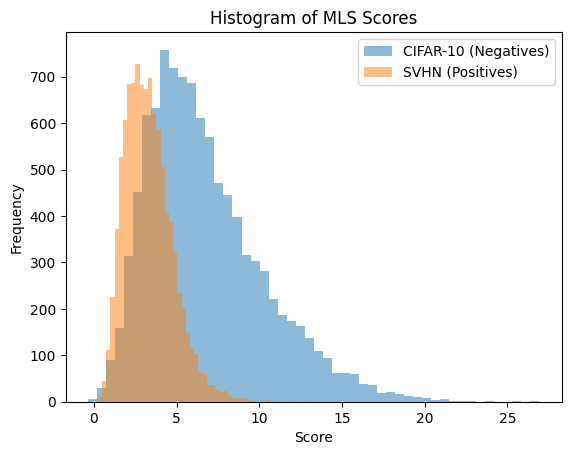

MLS AUROC: 0.1708
MLS Threshold for 0.9 TPR: 1.6177
Evaluating MSP...


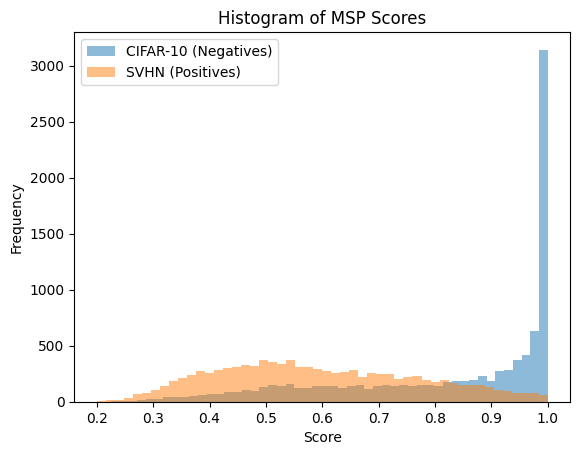

MSP AUROC: 0.1903
MSP Threshold for 0.9 TPR: 0.3701
Evaluating Energy...


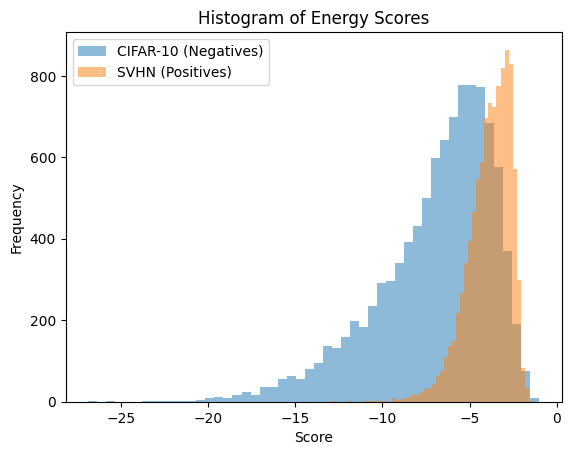

Energy AUROC: 0.8229
Energy Threshold for 0.9 TPR: -5.5031
Evaluating Entropy...


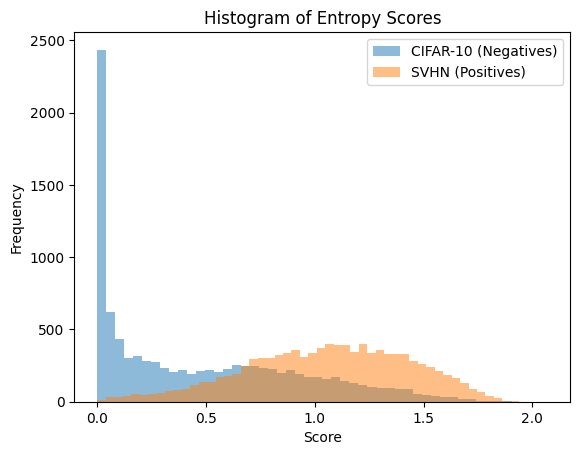

Entropy AUROC: 0.8279
Entropy Threshold for 0.9 TPR: 0.5526
Summary of OOD Score Metrics:
MLS: {'AUROC': 0.17080759, 'Threshold': 1.6176581, 'Accuracy': 0.46075, 'TPR': 0.9, 'Precision': 0.4791056694170881, 'Recall': 0.9, 'F1': 0.6253256904637833}
MSP: {'AUROC': 0.19034294000000002, 'Threshold': 0.37006265, 'Accuracy': 0.4606, 'TPR': 0.9, 'Precision': 0.47902916755375774, 'Recall': 0.9, 'F1': 0.6252605252188411}
Energy: {'AUROC': 0.8228582900000001, 'Threshold': -5.503103, 'Accuracy': 0.7497, 'TPR': 0.9, 'Precision': 0.6919883130862678, 'Recall': 0.9, 'F1': 0.7824045901069286}
Entropy: {'AUROC': 0.8279420650000001, 'Threshold': 0.55263275, 'Accuracy': 0.7509, 'TPR': 0.9, 'Precision': 0.6932676012940995, 'Recall': 0.9, 'F1': 0.7832216517274389}


In [34]:
# Define scoring functions
scoring_functions = {
    'MLS': mls,
    'MSP': msp,
    'Energy': lambda logits: energy(logits, temp=1),
    'Entropy': entropy
}

# Dictionary to store metrics for each method
metrics_dict = {}

for method, scoring_function in scoring_functions.items():
    print(f"Evaluating {method}...")

    # Compute scores for negatives (CIFAR-10) and positives (SVHN)
    scores_negatives = scoring_function(test_logits_negatives.cpu().numpy())
    scores_positives = scoring_function(test_logits_positives.cpu().numpy())

    # Plot histogram of scores
    plt.figure()
    plt.hist(scores_negatives, bins=50, alpha=0.5, label="CIFAR-10 (Negatives)")
    plt.hist(scores_positives, bins=50, alpha=0.5, label="SVHN (Positives)")
    plt.title(f"Histogram of {method} Scores")
    plt.xlabel("Score")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

    # Initialize dictionary for this method's metrics
    metrics_dict[method] = {}

    # Plot ROC curve and compute AUROC
    labels = np.concatenate([np.zeros_like(scores_negatives), np.ones_like(scores_positives)])
    scores = np.concatenate([scores_negatives, scores_positives])
    auroc = roc_auc_score(labels, scores)
    metrics_dict[method]['AUROC'] = auroc
    print(f"{method} AUROC: {auroc:.4f}")

    # Compute threshold for the given target TPR
    threshold = compute_threshold(scores_positives, target_tpr=0.9)
    metrics_dict[method]['Threshold'] = threshold
    print(f"{method} Threshold for 0.9 TPR: {threshold:.4f}")

    # Compute and store remaining metrics
    fixed_metrics = fixed_threshold_metrics(scores_negatives, scores_positives, threshold)
    metrics_dict[method].update(fixed_metrics)

# Print summary of all metrics
print("Summary of OOD Score Metrics:")
for method, metrics in metrics_dict.items():
    print(f"{method}: {metrics}")


### 6.2. Metrics for feature-based scores

**Exercise.** Extract the representations in the feature space given by the penultimate layer of the CNN of the three datasets: Cifar-10 training dataset, Cifar-10 test set and SVHN test set.

In [36]:
def compute_features(dataset, model, device):
    """
    Computes the feature representations from the penultimate layer of a CNN.

    Args:
    - dataset: DataLoader or dataset containing test samples.
    - model: Trained PyTorch model for inference.
    - device: Device to run the model on (e.g., 'cpu' or 'cuda').

    Returns:
    - features: Torch tensor containing feature representations for all samples in the dataset.
    """
    model.eval()  # Set the model to evaluation mode
    features = []

    # Modify the forward method to extract the penultimate layer output
    def forward_hook(module, input, output):
        features.append(output)

    # Register a forward hook to the penultimate layer (adjust layer name if different)
    hook = model.fc1.register_forward_hook(forward_hook)

    with torch.no_grad():
        for images, _ in dataset:  # Assuming the dataset is a DataLoader
            images = images.to(device)
            _ = model(images)  # Forward pass, hooks will capture the intermediate output

    # Remove the hook to avoid side effects
    hook.remove()

    # Concatenate features collected from all batches
    features = torch.cat(features, dim=0)
    return features
# Assuming DataLoader objects cifar_train_loader, cifar_test_loader, svhn_test_loader
# and the model is loaded as `model`, and device is 'cuda' or 'cpu'

train_features = compute_features(train_loader, model, device)
test_features_negatives = compute_features(cifar_test_loader, model, device)
test_features_positives = compute_features(svhn_test_loader, model, device)


**Exercise.**
1. Compute the *DKNN scores* for the Cifar-10 test dataset and the SVHN test datsets using the 5-th nearest neighbor.
2. Plot the histogram of the scores and check that the negative samples have, on average, lower scores than the positive samples.
2. Use the `roc_auc` function to plot the ROC curve and compute the AUROC.
3. Compute the trhreshold that achieves 0.1 FPR and compute the fixed-threshold metrics associated to it: accuracy, TPR, Precision, Recall and $F_1$.
4. Store all the metrics in the `metrics_dict` dictionary for future comparison.


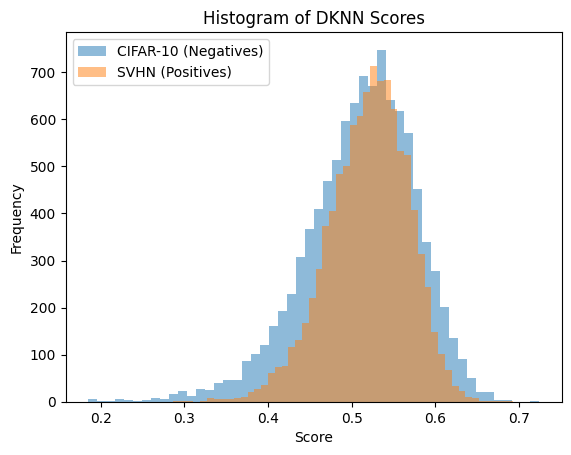

DKNN AUROC: 0.5324
DKNN Threshold for 0.9 TPR: 0.4577
DKNN Metrics Summary:
AUROC: 0.532395715
Threshold: 0.4577355980873108
Accuracy: 0.54745
TPR: 0.9
Precision: 0.5278282798662836
Recall: 0.9
F1: 0.6654097815237884


In [37]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

# Initialize metrics dictionary for DKNN
metrics_dict = {}
metrics_dict['DKNN'] = {}

# Initialize and fit the DKNN model
k = 5
dknn_model = DKNN(k=k, batch_size=256)  # Assuming the DKNN class from before
dknn_model.fit(train_features)  # Fit with CIFAR-10 training features

# Compute the scores for negatives (CIFAR-10 test set) and positives (SVHN test set)
scores_negatives = dknn_model.compute_scores(test_features_negatives)
scores_positives = dknn_model.compute_scores(test_features_positives)

# Plot the histogram of the scores
plt.figure()
plt.hist(scores_negatives, bins=50, alpha=0.5, label="CIFAR-10 (Negatives)")
plt.hist(scores_positives, bins=50, alpha=0.5, label="SVHN (Positives)")
plt.title("Histogram of DKNN Scores")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Plot ROC curve and compute AUROC
labels = np.concatenate([np.zeros_like(scores_negatives), np.ones_like(scores_positives)])
scores = np.concatenate([scores_negatives, scores_positives])
auroc = roc_auc_score(labels, scores)
metrics_dict['DKNN']['AUROC'] = auroc
print(f"DKNN AUROC: {auroc:.4f}")

# Compute threshold for the given target FPR (e.g., 0.1)
threshold = compute_threshold(scores_positives, target_tpr=0.9)
metrics_dict['DKNN']['Threshold'] = threshold
print(f"DKNN Threshold for 0.9 TPR: {threshold:.4f}")

# Compute and store fixed-threshold metrics
fixed_metrics = fixed_threshold_metrics(scores_negatives, scores_positives, threshold)
metrics_dict['DKNN'].update(fixed_metrics)

# Print summary of DKNN metrics
print("DKNN Metrics Summary:")
for metric, value in metrics_dict['DKNN'].items():
    print(f"{metric}: {value}")


**Exercise.**
1. Compute the *Mahalanobis scores* for the Cifar-10 test dataset and the SVHN test datsets using the 5-th nearest neighbor.
2. Plot the histogram of the scores and check that the negative samples have, on average, lower scores than the positive samples.
2. Use the `roc_auc` function to plot the ROC curve and compute the AUROC.
3. Compute the trhreshold that achieves 0.1 FPR and compute the fixed-threshold metrics associated to it: accuracy, TPR, Precision, Recall and $F_1$.
4. Store all the metrics in the `metrics_dict` dictionary for future comparison.

<ipython-input-29-0700d55d7e75>:47: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)
  distance = torch.sqrt(delta @ inv_cov @ delta.T)  # Mahalanobis distance formula


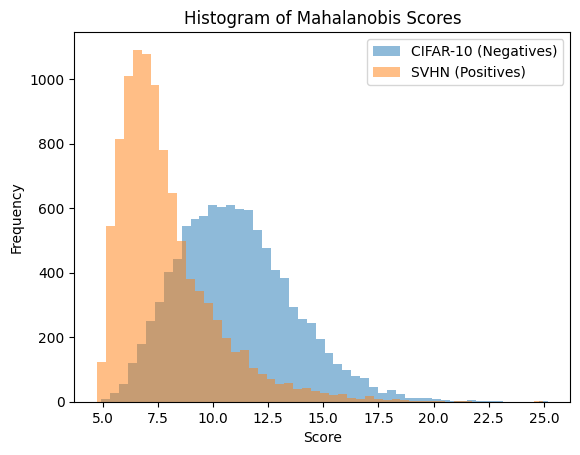

Mahalanobis AUROC: 0.1583
Mahalanobis Threshold for 0.9 TPR: 5.7227
Mahalanobis Metrics Summary:
AUROC: 0.15827267
Threshold: 5.7227301597595215
Accuracy: 0.45185
TPR: 0.9
Precision: 0.47460844803037494
Recall: 0.9
F1: 0.6214825812243208


In [40]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
# Extract labels directly
train_labels = torch.tensor([label for _, label in cifar_train])
# Initialize metrics dictionary for Mahalanobis
metrics_dict = {}
metrics_dict['Mahalanobis'] = {}

# Initialize and fit the Mahalanobis model
mahalanobis_model = Mahalanobis()
mahalanobis_model.fit(train_features, train_labels)  # Assuming `train_labels` are available

# Compute the scores for negatives (CIFAR-10 test set) and positives (SVHN test set)
scores_negatives = mahalanobis_model.compute_scores(test_features_negatives)
scores_positives = mahalanobis_model.compute_scores(test_features_positives)

# Plot the histogram of the scores
plt.figure()
plt.hist(scores_negatives, bins=50, alpha=0.5, label="CIFAR-10 (Negatives)")
plt.hist(scores_positives, bins=50, alpha=0.5, label="SVHN (Positives)")
plt.title("Histogram of Mahalanobis Scores")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Plot ROC curve and compute AUROC
labels = np.concatenate([np.zeros_like(scores_negatives), np.ones_like(scores_positives)])
scores = np.concatenate([scores_negatives, scores_positives])
auroc = roc_auc_score(labels, scores)
metrics_dict['Mahalanobis']['AUROC'] = auroc
print(f"Mahalanobis AUROC: {auroc:.4f}")

# Compute threshold for the given target TPR (e.g., 0.9)
threshold = compute_threshold(scores_positives, target_tpr=0.9)
metrics_dict['Mahalanobis']['Threshold'] = threshold
print(f"Mahalanobis Threshold for 0.9 TPR: {threshold:.4f}")

# Compute and store fixed-threshold metrics
fixed_metrics = fixed_threshold_metrics(scores_negatives, scores_positives, threshold)
metrics_dict['Mahalanobis'].update(fixed_metrics)

# Print summary of Mahalanobis metrics
print("Mahalanobis Metrics Summary:")
for metric, value in metrics_dict['Mahalanobis'].items():
    print(f"{metric}: {value}")


## Results Table
**Exercise.** Plot the results stored in the dictionary `metrics_dict` by highlighting the method that achieves the best value for each of the different metrics.

In [ ]:
# TODO: Display a table with the best results highlited.
# Careful! The best result is not always the maximum value!

**Bonus Exercises.** If you still have time, you can try and do the following:
1. Play with different temperature parameters in the *Energy* score to see how they affect the different metrics.
2. Play with different $k$ parameters in the *DKNN* algorithm to see how they affect the different metrics.
3. Write docstirngs for the above function (In the future, you will be greatful to your current self if you find yourself checking out this notebook and the docstrings are there).
4. Download a better model (e.g. a pre-trained VGG model fine-tuned on Cifar-10) and check out if you get better results with it.
5. Check out the OODEEL library where a benchmark like the one we have just carried-out is much easier to perform ;)